In [1]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain
import networkx as nx
from fa2 import ForceAtlas2
from collections import defaultdict
from nltk.corpus import wordnet as wn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

<p style="font-family:Muro;font-weight:bold;font-size:55px;margin:50px 0px 50px 0px;color:#ADD8E6;text-align: center">Sentiment Analysis</p>

In [2]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [3]:
df_dialog

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...
59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False


In [4]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [5]:
def get_character_lines_per_episode(character):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]
        
            character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [6]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [7]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [8]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return [lines for episode in episode_lines.values() for lines in episode.values()]

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Communities</p>

In [113]:
G = nx.readwrite.adjlist.read_adjlist("Data/GCC.gz")

In [ ]:
#Using the .best_partition method of the louvain algorithm, randomize is set to false so the results stay uniform
partition = community_louvain.best_partition(G, randomize=False)

#Counting the amount of communities
count = len(set(partition.values()))

#As well as the modularity
modu = community_louvain.modularity(partition, G)

#Printing out the answers to these two questions.
print(f"We found {count} communities in total.")
print(f"The modularity of the partition created is {modu}.")

In [ ]:
# We run Force Atlas 2 to get positions for the nodes

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Force Atlas Representation of The Office network, with nodes colored by community", c='black',  y=1.0, pad=-20)
d = dict(G.degree)
nx.draw_networkx(G, positions, nodelist=list(d.keys()), node_size=[v*5 for v in d.values()], node_color = list(partition.values()), with_labels=False, edge_color='grey', cmap="Set1")

In [ ]:
communities = defaultdict(list)

# Group characters into their communities 
for character, community in zip(partition.keys(),partition.values()):
    communities[community].append(character)

In [ ]:
named_communities = {}

for community in communities.values():
    sorted_com = sorted(community, key = lambda x : G.degree[x], reverse = True)
    name = ", ".join(sorted_com[:3]).replace("_", " ")
    print("----------")
    print(f"Community of {name}:")
    print("----------")
    for character in sorted_com[:10]:
        print(character.replace("_", " "))
    print()

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Wordclouds</p>

In [157]:
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()

def tokenize_text(text):
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation.replace("´","")))
    
    #Generating the tokens
    tokens = tk.tokenize(text)
    
    #Removing all the stopwords
    new_tokens = [token.lower() for token in tokens if token not in stopwords.words('english')]
    
    #Generating the lemmatizer and returning the output
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    
    return output

def tokenize_sentences(sentences):
    return tokenize_text(" ".join(sentences))

In [158]:
def tc(token_list):
    tc = {}
    tokens = [word for tokens in token_list for word in tokens]
    for key, value in nltk.FreqDist(tokens).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

def idf_log(token_list):
    unique_tokens = np.unique([word for tokens in token_list for word in tokens])
    idf = {}
    n_documents = len(token_list)
        
    for word in unique_tokens:
        n_documents_with_word = [1 for document in token_list if word in document]
        idf[word] = np.log((n_documents)/(len(n_documents_with_word)+1))
        
    return idf

def tc_logidf(tokens):
    tc_ = tc(tokens)
    idf_log_ = idf_log(tokens)  
    return {word:tc_[word]*math.ceil(idf_log_[word]) for word in tc_.keys()}
        
def tc_idf(tokens):
    tc_ = tc(tokens)
    idfs = idf(tokens)
    tc_idf = {}
    tokens = [word for token_list in tokens for word in token_list]
    for word in tokens:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

In [159]:
characters_to_analyze = ["Michael", "Jim", "Dwight", "Pam"]
characters_tokens = {}

for character in characters_to_analyze:
    texts = un_pack_episode_lines(character)
    tokens = [tokenize_sentences(text) for text in texts]
    
    characters_tokens[character] = tokens

In [160]:
from PIL import Image
link_mask = np.array(Image.open("jim.jpg"))

def make_wordcloud_image(character):
    
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items()]
    output = " ".join([word for lst in words_by_weight for word in lst])

    wordcloud = WordCloud(max_words=250, background_color="white", collocations=False, mask = link_mask, contour_width=3, contour_color='black').generate(output)
    plt.figure(figsize=[20,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.figtext(0.5, 0, f"Figure; {character.capitalize()}; WordCloud", wrap=True, horizontalalignment='center', fontsize=20)
    plt.show()

In [161]:
common_words = ["oh", "yeah", "ok", "im", "dont", "hey", "youre", "thats"]
def make_wordcloud(character):
    
    tc_idfs = tc_idf(characters_tokens[character])    
    words_by_weight = [[word]*weight for (word, weight) in tc_idfs.items() if "v" not in [t.pos() for t in wn.synsets(word)] and word not in common_words]
    output = " ".join([word for lst in words_by_weight for word in lst])
    
    wordcloud = WordCloud(max_words=150, background_color="white", collocations=False, contour_width=3, contour_color='black').generate(output)       
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {character}")
    plt.show()

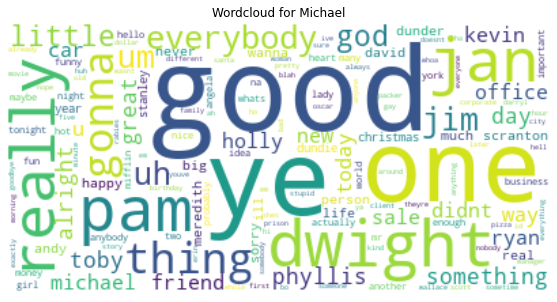

In [162]:
make_wordcloud("Michael")

In [166]:
surnames_and_names = "_".join(G.nodes()).split("_")
words_to_remove = ["episode", "season", "character", "carell", "wilson", "jenna", "fischer", "series", "tv", "u", "usnbs", "angeles", "los"] + [c.lower() for c in surnames_and_names]

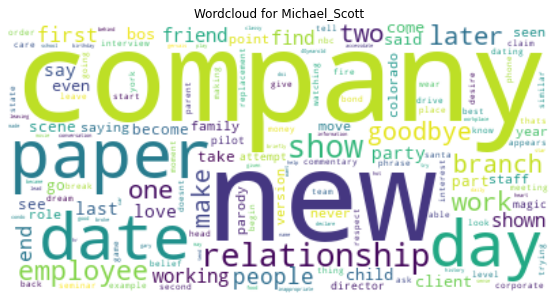

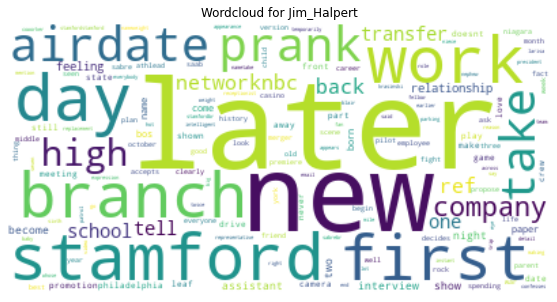

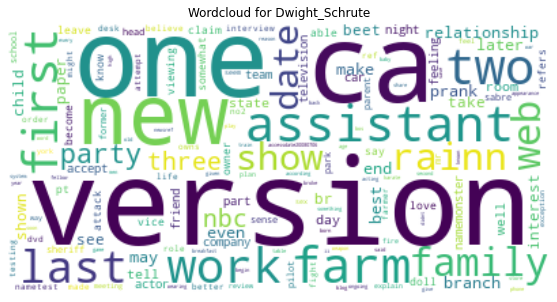

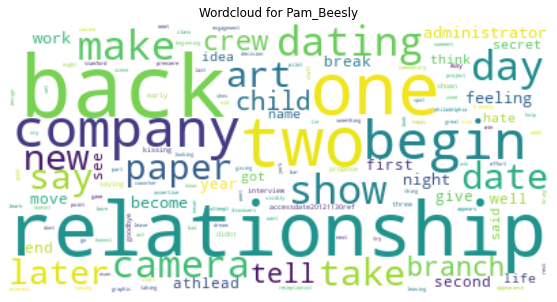

In [173]:
characters_to_analyze = ["Michael_Scott", "Jim_Halpert", "Dwight_Schrute", "Pam_Beesly"]
characters_tokens = {}
for character in characters_to_analyze:
    f = open(f"characters/{character}.txt", encoding="utf8")
    text = f.read() 
    text = text[:text.index("Appearances")]
    tokens = [token for token in tokenize_text(text) if all([w not in token for w in words_to_remove])]
    output = " ".join(tokens)   

    wordcloud = WordCloud(max_words=150, background_color="white", collocations=False, contour_width=3, contour_color='black').generate(output)    
    
    plt.figure(figsize=[10,5])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {character}")
    plt.show()

<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Sentiment Analysis</p>

In [18]:
df_aired = df_dialog[df_dialog.deleted == False]
characters_dialog = df_aired.speaker.unique()

In [19]:
def get_avg_sentiment_node_VADER(character):
    analyzer = SentimentIntensityAnalyzer()
    #character = character.split("_")[0]
    
    total = 0

    # otherwise, for each sentence in the character's dialogue
    dialogue = get_character_lines_series(character)
    for sentence in dialogue:
        # compute the polarity score
        vs = analyzer.polarity_scores(sentence)
        total += vs["compound"]
    
    # return the average sentiment across all sentences in the character's dialogue
    return total/len(dialogue)

In [20]:
char_sentiment_VADER = {char:get_avg_sentiment_node_VADER(char) for char in characters_dialog}
# sort sentiment
char_sentiment_VADER = dict(sorted(char_sentiment_VADER.items(), key=lambda item: item[1], reverse = True))

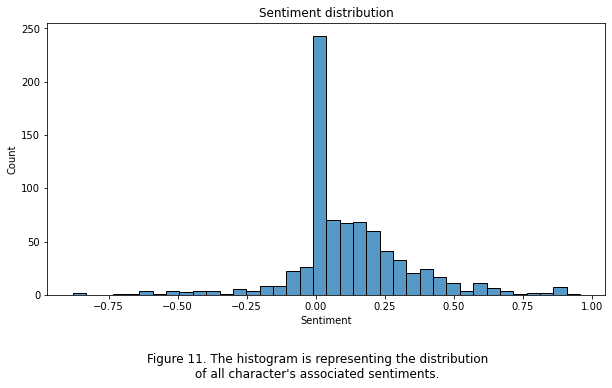

In [21]:
title = "Sentiment distribution"
caption = "Figure 11. The histogram is representing the distribution\nof all character's associated sentiments."
plt.figure(figsize=[10,5])
sns.histplot(char_sentiment_VADER)
plt.title(title)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [22]:
df_filepath = "Data/dataframe_characters.csv"
df = pd.read_csv(df_filepath)
main_characters = list(df[df.Category == "Main_Characters"]["Unnamed: 0"])
main_characters = [character.split(" ")[0] for character in main_characters]

C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


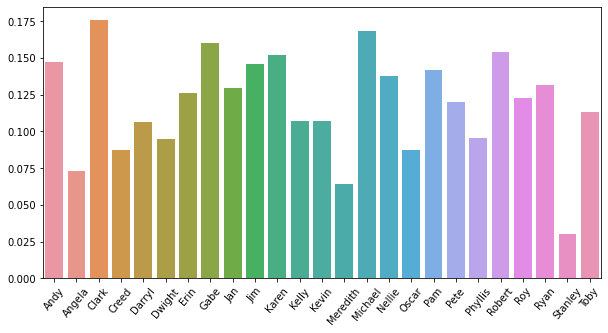

In [23]:
plt.figure(figsize=[10,5])
y = [char_sentiment_VADER[char] for char in main_characters]
sns.barplot(main_characters, y)
plt.xticks(rotation=50)
plt.show()

In [60]:
def get_sentiment_season(character):
    season_lines = get_character_lines_per_season(character)    
    total_per_seasons = []
    
    for season in range(1,10):
        
        if season not in season_lines.keys():
                total_per_seasons.append(None)
        else:
            lines = season_lines[season]
            total = 0
            analyzer = SentimentIntensityAnalyzer()       

            for sentence in lines:
                # compute the polarity score
                vs = analyzer.polarity_scores(sentence)
                total += vs["compound"]
            total_per_seasons.append(total/len(lines))
            
    return total_per_seasons

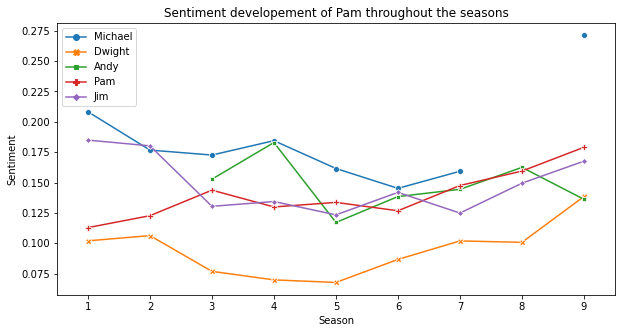

In [70]:
characters_sentiment = ["Michael", "Dwight", "Andy", "Pam", "Jim"]
data = pd.DataFrame({character:get_sentiment_season(character) for character in characters_sentiment}, index = list(range(1,10)))
plt.figure(figsize=[10,5])
sns.lineplot(data=data, markers=True, dashes=False)
plt.xlim(0.5,9.5)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title(f"Sentiment developement of {character} throughout the seasons")
plt.show()

In [ ]:
for character in ["Michael", "Dwight", "Andy", "Pam", "Jim"]:
    sns.set_theme()
    sentiment = get_sentiment_season(character)
    sns.lineplot(get_character_lines_per_season(character).keys(), sentiment, markers=True, dashes=False)
    plt.xlim(1,9)
    plt.xlabel('Season')
    plt.ylabel('Sentiment')
    plt.title(f"Sentiment developement of {character} throughout the seasons")
    plt.show()